### **Supplementary Figure 2-4: Comparing Histogram and k-NN estimators of KL divergence**

Optimised Histogram MIND network edges and degrees per subject are saved to output/SF2-4/hist_opt_edge_per_subj.csv and output/SF2-4/hist_opt_degree_per_subj.csv. If using these, 1.4 does not need to be run.

Results of age prediction are provided. If using these, 1.8 does not need to be run

#### **1.1 Setup**

In [13]:
# Autoreload
%load_ext autoreload
%autoreload 2

# Import helper functions
import sys
sys.path.append('code')
from preprocessing_helpers import *
from plotting_helpers import *
from Sup_MIND_helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### **1.2 Simulations**

Here, we explore the effects of parameter modulation on estimation of KL divergence for a single edge, i.e. between a single pair of regions, from the value obtained with default parameters. This is repeated for the Histogram and k-NN estimator.

The regions used (left primary visual cortex, V1_L and left entorhinal cortex, Ent_L) are taken from the average T1w/T2w scan, obtained by taking the mean across all spatially co-registered T1w/T2w images. Begin by plotting these region distributions

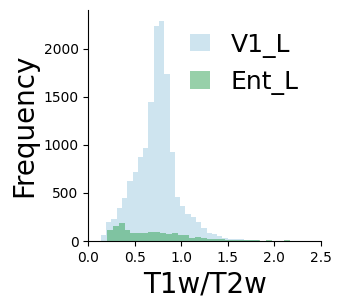

In [8]:
vox_df = pd.read_csv('output/SF2-4/Average_T1wT2w_vox.csv')

roi_A = 'V1_L'
roi_B = 'Ent_L'
A = vox_df[vox_df['Label'] == roi_A]['Value']
B = vox_df[vox_df['Label'] == roi_B]['Value']

plt.figure(figsize=(3, 3))
plt.hist(A, bins=50, alpha=0.5, label=roi_A, rasterized=True, color='#9ecae1')
plt.hist(B, bins=50, alpha=0.5, label=roi_B, rasterized=True, color='#31a354')
plt.xlabel('T1w/T2w', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend(frameon=False, fontsize=18, handlelength=0.8)
plt.xlim([0, 2.5])
ax=plt.gca(); ax.spines[['top', 'right']].set_visible(False)
plt.show()

In [9]:
# Generate parameter dictionary for KNN and Histogram KL estimators
params_dict = {
    'k-NN':{
        'params':{
            'k':[0, 1, 2, 3, 4],  # Number of neighbors
            'pctiles':[[0, 100], [0.1, 99.9], [1, 99], [2.5, 97.5], [5, 95]]  # Percentile ranges for filtering
        },
        'param_names':{
            'k':'k',
            'pctiles':'Percentiles'
        },
        'results':np.zeros((2, 5))  # Results matrix: 2 parameter types × 5 parameter values
    },
    'Histogram':{
        'params':{
            'nbins':[32, 64, 128, 256, 512],  # Number of bins
            'epsilon':[2.2e-16, 1e-14, 1e-12, 1e-10, 1e-8],  # Small constant for numerical stability
            'pctiles':[[0, 100], [0.1, 99.9], [1, 99], [2.5, 97.5], [5, 95]]  # Percentile ranges for filtering
        },
        'param_names':{
            'nbins':'Number of bins',
            'epsilon':'Log10(Epsilon)',
            'pctiles':'Percentiles'
        },
        'results':np.zeros((3, 5))  # Results matrix: 3 parameter types × 5 parameter values
    }
}

# Construct dataframe with values and group labels
df = pd.concat([
    pd.DataFrame({'Value':A, 'Label':[1]*len(A)}),
    pd.DataFrame({'Value':B, 'Label':[2]*len(B)})
], axis=0)

# -------------------------------------------------------------------
# KNN KL divergence
# -------------------------------------------------------------------

# Compute baseline (default) KL divergence with KNN estimator
_, knn_kl_default, _, _ = calculate_knn_mind(df, ['Value'], df['Label'].unique())

# Iterate through parameter types and values
mind_type = params_dict['k-NN']
for param_type_idx, param_type in enumerate(list(mind_type['params'].keys())):
    current_params = mind_type['params'][param_type]

    for param_idx, param in enumerate(current_params):
        
        # Apply filtering if parameter type is percentiles
        if param_type == 'pctiles':
            vox_df_filt = vox_df[
                (vox_df['Value'] > np.nanpercentile(vox_df['Value'], param[0])) & 
                (vox_df['Value'] < np.nanpercentile(vox_df['Value'], param[1]))
            ]
            
            # Reconstruct filtered distributions for A and B
            A_filt = vox_df_filt[vox_df_filt['Label'] == roi_A]['Value']
            B_filt = vox_df_filt[vox_df_filt['Label'] == roi_B]['Value']
            df_filt = pd.concat([
                pd.DataFrame({'Value':A_filt, 'Label':[1]*len(A_filt)}),
                pd.DataFrame({'Value':B_filt, 'Label':[2]*len(B_filt)})
            ], axis=0)

            # Compute KL with filtered data
            _, knn_kl, _, _ = calculate_knn_mind(df_filt, ['Value'], df_filt['Label'].unique())
        else:
            # Compute KL with current parameter
            _, knn_kl, _, _ = calculate_knn_mind(df, ['Value'], df['Label'].unique(), **{param_type: param})

        # Store % change relative to default KL
        mind_type['results'][param_type_idx, param_idx] = (
            (knn_kl[0][1] - knn_kl_default[0][1]) / knn_kl_default[0][1] * 100
        )

# -------------------------------------------------------------------
# Histogram KL divergence
# -------------------------------------------------------------------

# Compute baseline (default) KL divergence with histogram estimator
_, hist_kl_default, _, _ = calculate_hist_mind(df, ['Value'], ['Label'])

# Iterate through parameter types and values
mind_type = params_dict['Histogram']
for param_type_idx, param_type in enumerate(list(mind_type['params'].keys())):
    current_params = mind_type['params'][param_type]

    for param_idx, param in enumerate(current_params):
        # Compute KL with current parameter
        _, hist_kl, _, _ = calculate_hist_mind(df, ['Value'], ['Label'], **{param_type: param})

        # Store % change relative to default KL
        mind_type['results'][param_type_idx, param_idx] = (
            (hist_kl[0][1] - hist_kl_default[0][1]) / hist_kl_default[0][1] * 100
        )

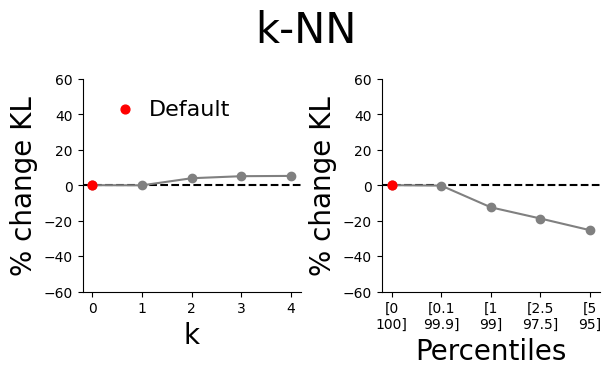

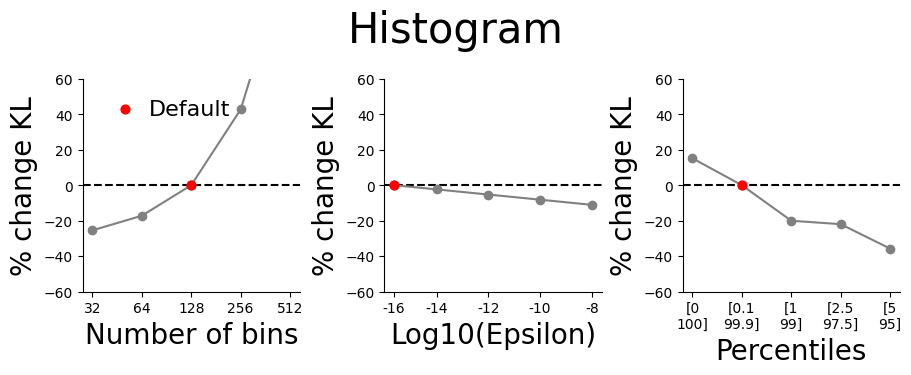

In [10]:
from matplotlib.ticker import FuncFormatter

# Formatter to display values on x-axis without decimals
formatter = FuncFormatter(lambda val, _: f'{val:.0f}')

# Iterate over MIND estimator types (k-NN, Histogram)
for mind_name, mind_data in params_dict.items():
    params = mind_data['params']
    results = mind_data['results']
    n_params = len(params)

    # Create one subplot per parameter type
    fig, axes = plt.subplots(1, n_params, figsize=(3 * n_params, 3), constrained_layout=True)
    if n_params == 1:
        axes = [axes]  # Ensure axes is iterable when single parameter

    # Loop over parameter types and values
    for idx, (param_name, param_values) in enumerate(params.items()):
        ax = axes[idx]

        # Format x-axis labels depending on parameter type
        x = [
            f"[{p[0]}\n{p[1]}]" if isinstance(p, list) else p
            for p in param_values
        ]
        y = results[idx]

        if param_name == 'epsilon': 
            x = np.log10(x)  # Use log10 scale for epsilon
        if param_name == 'nbins':
            x = ['32', '64', '128', '256', '512']  # Display bins as strings

        # Plot parameter sweep results
        ax.plot(x, y, marker='o', color='grey')
        ax.axhline(0, linestyle='dashed', color='k', zorder=0)

        # Highlight default parameter values
        for i, val in enumerate(y):
            if np.isclose(val, 0, atol=1e-2):
                ax.scatter(x[i], y[i], color='red', zorder=5, s=40, label='Default')

        # Formatting: ticks, labels, axes
        ax.set_xticks(x)                
        ax.set_xticklabels(x, rotation=0, fontsize=10) 
        if param_name == 'epsilon':
            ax.xaxis.set_major_formatter(formatter)
        ax.set_xlabel(mind_data['param_names'][param_name], fontsize=20)
        ax.set_ylabel('% change KL', fontsize=20)
        ax.set_ylim([-60, 60])

        # Add legend only for first subplot
        if idx == 0:
            ax.legend(frameon=False, loc='upper left', fontsize=16, handletextpad=0.1)

        ax.tick_params(axis='x', rotation=0)
        ax.spines[['top', 'right']].set_visible(False)

    # Add title per estimator type
    fig.suptitle(f'{mind_name}', fontsize=30, y=1.2)
    plt.show()

Here, we explore the effects of parameter modulation at the whole network level, i.e. across all edges. Networks are estimated using a range of parameters, and the correlation between the upper triangle of each of these networks with the default network is computed.

In [ ]:
# Repeating this at network level
import pickle

# ----- Set parameters ----- #
params_dict = {
    'k-NN':{
        'k':{
            'params':[0, 1, 2, 3, 4],   # Number of neighbors
            'edges':[]
        },
        'pctiles':{
            'params':[[0, 100], [0.1, 99.9], [1, 99], [2.5, 97.5], [5, 95]],  # Percentile ranges
            'edges':[]
        }
    },
    'Histogram':{
        'nbins':{
            'params':[32, 64, 128, 256, 512],  # Number of bins
            'edges':[]
        },
        'epsilon':{
            'params':[np.finfo(float).eps, 1e-14, 1e-12, 1e-10, 1e-8],  # Small constants for stability
            'edges':[]
        },
        'pctiles':{
            'params':[[0, 100], [0.1, 99.9], [1, 99], [2.5, 97.5], [5, 95]],  # Percentile ranges
            'edges':[]
        }
    } 
}

# ----- Calculate networks ----- #

# Load voxel-level data
vox_df = pd.read_csv('output/SF2-4/Average_T1wT2w_vox.csv')

# Assign unique ROI-side label
vox_df['uq'] = vox_df['ROI'] + '_' + vox_df['Side']
uq_mapping = {uq: idx for idx, uq in enumerate(vox_df['uq'].unique(), start=1)}
vox_df['Label'] = vox_df['uq'].map(uq_mapping)
labs = vox_df['Label'].unique()

# Get indices for upper triangle of adjacency matrix
n_rois = vox_df['Label'].nunique()
n_edges = int((n_rois**2 - n_rois) / 2)
triu_ind = np.triu_indices(n_rois, k=1)

# Loop through parameter sets, compute networks, extract edges
for mind_type in params_dict.keys():
    params = params_dict[mind_type]
    for param_type in list(params.keys()):
        current_params = params[param_type]['params']

        # Initialize storage for edges (one row per parameter value)
        edges_df = np.zeros((len(current_params), n_edges))

        for param_idx, param in tqdm(enumerate(current_params)):
            if mind_type == 'k-NN':
                mind, _, _, _ = calculate_knn_mind(vox_df, ['Value'], labs, **{param_type: param})
            elif mind_type == 'Histogram':
                mind, _, _, _ = calculate_hist_mind(vox_df, ['Value'], ['Label'], **{param_type: param})

            # Store edges from upper triangle
            edges_df[param_idx, :] = mind[triu_ind]

        # Save parameter-specific results
        params_dict[mind_type][param_type]['edges'] = edges_df

# ----- Save dictionary ----- #

# Save results to file
with open("output/SF2-4/params_dict.pkl", "wb") as f:
    pickle.dump(params_dict, f)


5it [05:15, 63.07s/it]
5it [04:54, 58.84s/it]
5it [00:05,  1.15s/it]
5it [00:05,  1.08s/it]
5it [00:05,  1.12s/it]


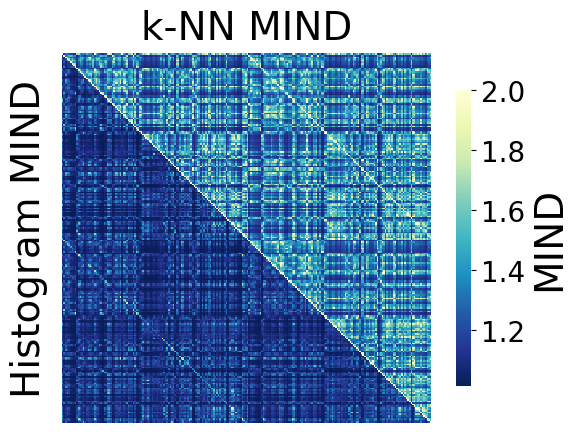

In [12]:
# Visualise networks
import pickle

# Load results
with open("output/SF2-4/params_dict.pkl", "rb") as f:
    params_dict = pickle.load(f)

triu_ind = np.triu_indices(230, k=1)

knn_mat = np.ones((230, 230)); knn_mat[triu_ind] = params_dict['k-NN']['k']['edges'][0]
hist_mat = np.ones((230, 230)); hist_mat[triu_ind] = params_dict['Histogram']['epsilon']['edges'][0]

mat = knn_mat + hist_mat.T

ax = sns.heatmap(mat, cmap='YlGnBu_r', xticklabels=[], yticklabels=[], 
            cbar_kws={'shrink': 0.8, 'label': 'MIND'}, rasterized=True)
cbar = ax.collections[0].colorbar  # Get the color bar
cbar.ax.yaxis.label.set_size(28) 
cbar.ax.tick_params(labelsize=20)
plt.title('k-NN MIND', fontsize=28, pad=10)
plt.ylabel('Histogram MIND', fontsize=28, labelpad=10)
ax.set_aspect("equal")
plt.show()


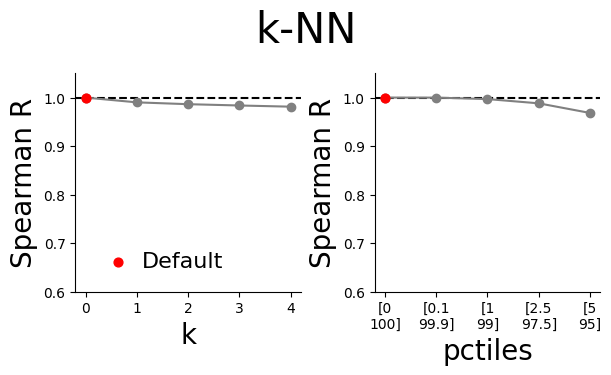

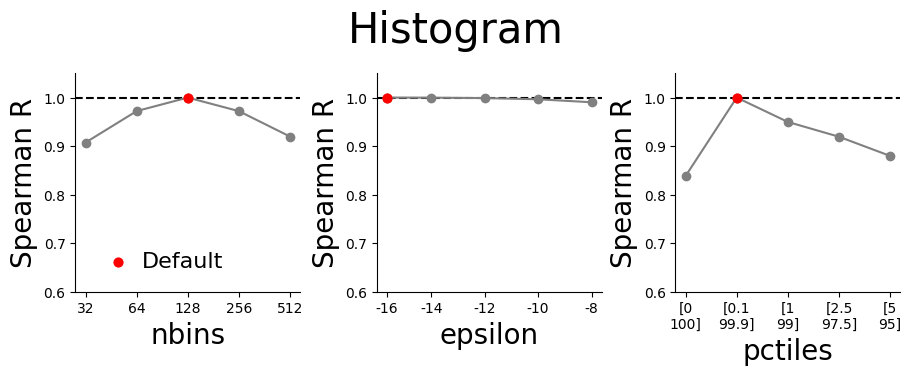

In [13]:
from matplotlib.ticker import FuncFormatter

# ----- Load results ----- #
with open("output/SF2-4/params_dict.pkl", "rb") as f:
    params_dict = pickle.load(f)

# Formatter for epsilon values (log scale, no decimals)
formatter = FuncFormatter(lambda val, _: f'{val:.0f}')

# ----- Correlate default networks with parameter sweeps ----- #
for mind_name, params in params_dict.items():
    n_params = len(params)

    # One subplot per parameter type
    fig, axes = plt.subplots(1, n_params, figsize=(3 * n_params, 3), constrained_layout=True)
    if n_params == 1:
        axes = [axes]  # Ensure axes is iterable if only one parameter

    for idx, (param_name, data) in enumerate(params.items()):
        param_values = data['params']
        edges = data['edges']

        ax = axes[idx]

        # Format x-axis depending on parameter type
        x = [
            f"[{p[0]}\n{p[1]}]" if isinstance(p, list) else p
            for p in param_values
        ]

        # Select default edge set for correlation
        if mind_name == 'k-NN':
            default_edges = params_dict['k-NN']['pctiles']['edges'][0, :]  # first percentile setting
        elif mind_name == 'Histogram':
            default_edges = params_dict['Histogram']['nbins']['edges'][2, :]  # nbins=128

        # Compute Spearman correlations vs. default edges
        y = []
        for param_idx, param in enumerate(param_values):
            current_edges = edges[param_idx, :]
            y.append(spearmanr(default_edges, current_edges)[0])

        # Adjust x-axis representation
        if param_name == 'epsilon':
            x = np.log10(x)
        if param_name == 'nbins':
            x = ['32', '64', '128', '256', '512']

        # Plot correlations
        ax.plot(x, y, marker='o', color='grey')
        ax.axhline(1, linestyle='dashed', color='k', zorder=0)

        # Highlight default parameter value
        for i, val in enumerate(y):
            if np.isclose(val, 1, atol=0):
                ax.scatter(x[i], y[i], color='red', zorder=5, s=40, label='Default')

        # Format axis labels and style
        ax.set_xticks(x)
        ax.set_xticklabels(x, rotation=0, fontsize=10)
        if param_name == 'epsilon':
            ax.xaxis.set_major_formatter(formatter)
        ax.set_xlabel(param_name, fontsize=20)
        ax.set_ylabel('Spearman R', fontsize=20)
        ax.set_ylim([0.6, 1.05])

        # Add legend only on first subplot
        if idx == 0:
            ax.legend(frameon=False, loc='lower left', fontsize=16, handletextpad=0.1)

        ax.tick_params(axis='x', rotation=0)
        ax.spines[['top', 'right']].set_visible(False)

    # Title per estimator type
    fig.suptitle(f'{mind_name}', fontsize=30, y=1.2)
    plt.show()

#### **1.3 Selecting Histogram algorithm parameters using anatomical benchmarks**

Using the same mean T1w/T2w image, generate Histogram networks using combinations of parameters (n_bins and pctiles)

In [ ]:
# Generate networks with combinations of nbins and pctiles 
import itertools as it

# ----- Load voxel data ----- #
vox_df = pd.read_csv('output/SF2-4/Average_T1wT2w_vox.csv')

# Map string labels to numeric labels
uq_mapping = {uq: idx for idx, uq in enumerate(vox_df['Label'].unique(), start=1)}
vox_df['Label_num'] = vox_df['Label'].map(uq_mapping)

# ----- Define parameter space ----- #
params_dict = {
    'nbins':[32, 64, 128, 256, 512],  # number of histogram bins
    'epsilon':[np.finfo(float).eps],  # small constant for stability
    'pctiles':[[5, 95], [2.5, 97.5], [1, 99], [0.1, 99.9], [0, 100]]  # percentile cutoffs
}

# Generate all parameter combinations
combinations = list(it.product(*params_dict.values()))

# Store parameter combinations in dataframe (with sorting index)
params_df = pd.concat([
    pd.DataFrame(combinations, columns=list(params_dict.keys())),
    pd.DataFrame({'sort':np.array(range(1, len(combinations)+1)).astype(int)})
], axis=1)

# Save parameter table
params_df.to_csv('output/SF2-4/histogram_MIND_param_df.csv')

# ----- Compute networks for each parameter combination ----- #
for idx, row in tqdm(params_df.iterrows()):
    nbins = row['nbins']
    epsilon = row['epsilon']
    pctiles = row['pctiles']
    
    print(f'Calculating network with parameters: nbins={nbins}, epsilon={epsilon}, pctiles={pctiles}')

    # Compute histogram-based MIND network
    MIND_net, _, _, _ = calculate_hist_mind(
        vox_df, ['Value'], ['Label_num'], nbins=nbins, epsilon=epsilon, pctiles=pctiles
    )
    
    # Save adjacency matrix
    save_dir = 'output/SF2-4/histogram_parameter_MIND/'
    os.makedirs(save_dir, exist_ok=True)
    save_path = save_dir + 't12_MIND_hist_' + str(idx + 1) + '.csv'
    pd.DataFrame(MIND_net).to_csv(save_path)


0it [00:00, ?it/s]

Calculating network with parameters: nbins=32, epsilon=2.220446049250313e-16, pctiles=[5, 95]


1it [00:01,  1.14s/it]

Calculating network with parameters: nbins=32, epsilon=2.220446049250313e-16, pctiles=[2.5, 97.5]


2it [00:02,  1.10s/it]

Calculating network with parameters: nbins=32, epsilon=2.220446049250313e-16, pctiles=[1, 99]


3it [00:03,  1.11s/it]

Calculating network with parameters: nbins=32, epsilon=2.220446049250313e-16, pctiles=[0.1, 99.9]


4it [00:04,  1.11s/it]

Calculating network with parameters: nbins=32, epsilon=2.220446049250313e-16, pctiles=[0, 100]


5it [00:05,  1.04s/it]

Calculating network with parameters: nbins=64, epsilon=2.220446049250313e-16, pctiles=[5, 95]


6it [00:06,  1.05s/it]

Calculating network with parameters: nbins=64, epsilon=2.220446049250313e-16, pctiles=[2.5, 97.5]


7it [00:07,  1.06s/it]

Calculating network with parameters: nbins=64, epsilon=2.220446049250313e-16, pctiles=[1, 99]


8it [00:08,  1.06s/it]

Calculating network with parameters: nbins=64, epsilon=2.220446049250313e-16, pctiles=[0.1, 99.9]


9it [00:09,  1.08s/it]

Calculating network with parameters: nbins=64, epsilon=2.220446049250313e-16, pctiles=[0, 100]


10it [00:10,  1.09s/it]

Calculating network with parameters: nbins=128, epsilon=2.220446049250313e-16, pctiles=[5, 95]


11it [00:12,  1.13s/it]

Calculating network with parameters: nbins=128, epsilon=2.220446049250313e-16, pctiles=[2.5, 97.5]


12it [00:13,  1.21s/it]

Calculating network with parameters: nbins=128, epsilon=2.220446049250313e-16, pctiles=[1, 99]


13it [00:14,  1.19s/it]

Calculating network with parameters: nbins=128, epsilon=2.220446049250313e-16, pctiles=[0.1, 99.9]


14it [00:15,  1.17s/it]

Calculating network with parameters: nbins=128, epsilon=2.220446049250313e-16, pctiles=[0, 100]


15it [00:16,  1.16s/it]

Calculating network with parameters: nbins=256, epsilon=2.220446049250313e-16, pctiles=[5, 95]


16it [00:17,  1.16s/it]

Calculating network with parameters: nbins=256, epsilon=2.220446049250313e-16, pctiles=[2.5, 97.5]


17it [00:19,  1.21s/it]

Calculating network with parameters: nbins=256, epsilon=2.220446049250313e-16, pctiles=[1, 99]


18it [00:20,  1.23s/it]

Calculating network with parameters: nbins=256, epsilon=2.220446049250313e-16, pctiles=[0.1, 99.9]


19it [00:21,  1.23s/it]

Calculating network with parameters: nbins=256, epsilon=2.220446049250313e-16, pctiles=[0, 100]


20it [00:23,  1.22s/it]

Calculating network with parameters: nbins=512, epsilon=2.220446049250313e-16, pctiles=[5, 95]


21it [00:24,  1.32s/it]

Calculating network with parameters: nbins=512, epsilon=2.220446049250313e-16, pctiles=[2.5, 97.5]


22it [00:25,  1.34s/it]

Calculating network with parameters: nbins=512, epsilon=2.220446049250313e-16, pctiles=[1, 99]


23it [00:27,  1.32s/it]

Calculating network with parameters: nbins=512, epsilon=2.220446049250313e-16, pctiles=[0.1, 99.9]


24it [00:28,  1.32s/it]

Calculating network with parameters: nbins=512, epsilon=2.220446049250313e-16, pctiles=[0, 100]


25it [00:29,  1.19s/it]


Pass these networks through anatomical benchmarks: cytoarchitecture, symmetry, and tract tracing. Extract 1) the proportion of intra-class edges, 2) the proportion of homotopic edges, and 3) correlation with tract tracing data over a range of network densities. Then extract the area under the curve to yield three biological performance metrics for each network

In [14]:
# Run these through biological validations

# ----- Load network metadata ----- #
net_type_lut = pd.read_csv('output/SF2-4/histogram_MIND_param_df.csv', index_col=0)  # parameter combinations
net_type_dir = 'output/SF2-4/histogram_parameter_MIND/'  # directory containing networks

# ----- Load lookup table (ROI info) ----- #
lut = pd.read_csv('data/lut_master.csv', index_col=0)
lut_lh = lut[lut['Side'] == 'L']  # left hemisphere ROIs only

# Cortical class labels (e.g. cytoarchitecture type)
emp = lut['type']

# ----- Load tract tracing data ----- #
tt = pd.read_csv('data/tract_tracing_matrix_edge_complete.csv', index_col=0)
tt_rois = tt.columns.tolist()

# ROI indices to filter MIND matrix (matching tract tracing ROIs)
tt_roi_ind = lut_lh[lut_lh['ROI'].isin(tt_rois)].index.tolist()
tt_triu_ind = np.triu_indices(len(tt_roi_ind), k=1)
tt_triu = tt.values[tt_triu_ind]  # upper triangle of tract tracing matrix

# ----- Initialise results storage ----- #
results_dict = {
    'Cytoarchitecture':[],
    'Symmetry':[],
    'Tract tracing':[]
}

# ----- Loop through parameterized networks ----- #
for idx, row in tqdm(net_type_lut.iterrows()):
    # Load MIND network
    filename = 't12_MIND_hist_' + str(int(row['sort'])) + '.csv'
    fullpath = os.path.join(net_type_dir, filename)
    MIND_net = pd.read_csv(fullpath, header=0, index_col=0)
        
    # ----- Validation 1: Intra-class edges (cytoarchitecture) ----- #
    dens_list = np.arange(0.5, 100, 0.5)
    pct_intraclass_list = []
    for dens in dens_list:
        net_thresh = threshold_network(MIND_net.iloc[0:116, 0:116].values, dens)
        pct_intraclass = get_pct_intraclass(net_thresh, emp)
        pct_intraclass_list.append(pct_intraclass)
    # Area under curve across densities
    results_dict['Cytoarchitecture'].append(np.trapz(pct_intraclass_list, dens_list))

    # ----- Validation 2: Interhemispheric symmetry ----- #
    dens_list = np.arange(0.5, 100, 0.5)
    pct_interhem_list = []
    for dens in dens_list:
        net_thresh = threshold_network(MIND_net.values, dens)
        pct_interhem = get_pct_interhemispheric(net_thresh)
        pct_interhem_list.append(pct_interhem)
    results_dict['Symmetry'].append(np.trapz(pct_interhem_list, dens_list))
    
    # ----- Validation 3: Tract tracing correlation ----- #
    dens_list = np.arange(0.5, 100, 0.5)
    tt_list = []
    for dens in dens_list:
        net_thresh = threshold_network(MIND_net.values, dens)
        net_thresh_filt = net_thresh[tt_roi_ind, :][:, tt_roi_ind]
        to_plot = pd.DataFrame({'a':net_thresh_filt[tt_triu_ind], 'b':tt_triu}).dropna()
        tt_list.append(spearmanr(to_plot["a"], to_plot["b"])[0])
    results_dict['Tract tracing'].append(np.trapz(tt_list, dens_list))

25it [00:46,  1.86s/it]


In [15]:
# Convert validation results dictionary to dataframe
results_df = pd.DataFrame(results_dict)

# ----- Compute ranks for each validation metric ----- #

# Rank cytoarchitecture AUC (higher = better)
results_df['cyto_rank'] = results_df['Cytoarchitecture'].round().rank(ascending=False)

# Rank interhemispheric symmetry AUC
results_df['sym_rank'] = results_df['Symmetry'].round().rank(ascending=False)

# Rank tract tracing AUC (rounded to 2 sig figs before ranking)
results_df['tt_rank'] = results_df['Tract tracing'].apply(lambda x: f'{x:.2g}').rank(ascending=False)

# ----- Compute combined rank ----- #
results_df['rank_all'] = results_df[['cyto_rank', 'sym_rank', 'tt_rank']].mean(axis=1)

# Sort networks by overall average rank
results_df.sort_values('rank_all')

,Cytoarchitecture,Symmetry,Tract tracing,cyto_rank,sym_rank,tt_rank,rank_all
3,29.271472,91.528261,27.310655,3.0,2.0,13.5,6.166667
8,28.465627,91.200000,26.807189,6.5,4.0,13.5,8.000000
9,31.889896,81.256522,30.753707,1.0,22.0,1.0,8.000000
23,27.655417,85.289130,30.008649,6.5,17.0,3.0,8.833333
14,28.966683,90.247826,25.953932,3.0,7.0,18.0,9.333333
19,28.598563,91.267391,24.519176,3.0,4.0,21.5,9.500000
13,27.999114,89.684783,26.379517,6.5,7.0,18.0,10.500000
24,28.266284,90.141304,25.107358,6.5,7.0,21.5,11.666667
18,27.483789,87.902174,28.047218,15.5,12.0,9.5,12.333333
17,27.388901,84.397826,30.328829,15.5,18.5,3.0,12.333333


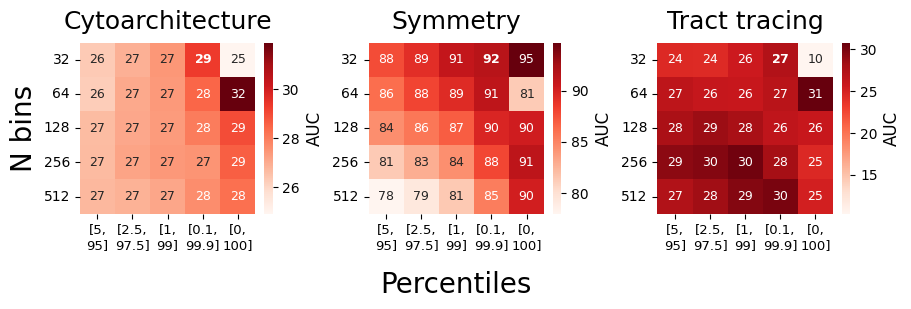

In [16]:
# Visualise results

# ----- Create figure with one subplot per validation metric ----- #
fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), constrained_layout=True)
axs = axs.flatten()

to_plot = ['Cytoarchitecture', 'Symmetry', 'Tract tracing']

# ----- Define parameter space ----- #
params_dict = {
    'nbins':[32, 64, 128, 256, 512],  # number of histogram bins
    'epsilon':[np.finfo(float).eps],  # small constant for stability
    'pctiles':[[5, 95], [2.5, 97.5], [1, 99], [0.1, 99.9], [0, 100]]  # percentile cutoffs
}

# ----- Loop through validation metrics ----- #
for idx, validation in enumerate(to_plot): 
    
    # Reshape results into 5×5 matrix (nbins × pctiles)
    to_plot = np.array(results_dict[validation]).reshape(5, 5)

    # Build annotation matrix (values as strings, bold one cell for emphasis)
    annot_matrix = np.empty(to_plot.shape, dtype=object)
    for i in range(to_plot.shape[0]):
        for j in range(to_plot.shape[1]):
            value = f"{to_plot[i, j]:.2g}"
            if i == 0 and j == 3:  
                annot_matrix[i, j] = rf"$\bf{{{value}}}$"  # bold formatting
            else:
                annot_matrix[i, j] = value
    
    # Plot heatmap
    ax = axs[idx]
    heatmap = sns.heatmap(
        to_plot, cmap='Reds', 
        xticklabels=params_dict['pctiles'],
        yticklabels=params_dict['nbins'],
        annot=annot_matrix, fmt='', annot_kws={"size": 9}, ax=ax, rasterized=True
    )

    # Colorbar formatting
    cbar = heatmap.collections[0].colorbar
    cbar.ax.set_ylabel("AUC", fontsize=12)

    # Titles and axis formatting
    ax.set_title(validation, fontsize=18, pad=10)
    ticks = ['[5,\n95]', '[2.5,\n97.5]', '[1,\n99]', '[0.1,\n99.9]', '[0,\n100]']
    ax.set_xticklabels(ticks, fontsize=9.5, rotation=0, ha='center')
    ax.tick_params(axis='y', labelrotation=0)
    if idx == 0: 
        ax.set_ylabel('N bins', fontsize=20)

# Shared x-axis label
fig.text(0.5, -0.15, 'Percentiles', ha='center', fontsize=20)
plt.show()


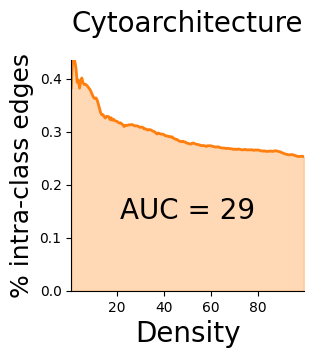

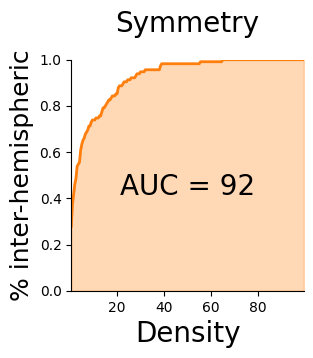

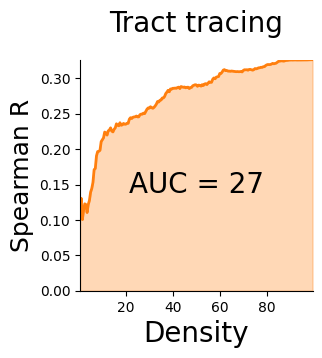

In [17]:
# Display best curve / correlation

# ----- Load best-performing network ----- #
best_sort = 4
filename = f't12_MIND_hist_{best_sort}.csv'
fullpath = os.path.join(net_type_dir, filename)
MIND_net = pd.read_csv(fullpath, header=0, index_col=0)

# ----- Plot cytoarchitecture AUC ----- #
dens_list = np.arange(0.5, 100, 0.5)
pct_intraclass_list = []
for dens in dens_list:
    net_thresh = threshold_network(MIND_net.iloc[0:116, 0:116].values, dens)
    pct_intraclass = get_pct_intraclass(net_thresh, emp)
    pct_intraclass_list.append(pct_intraclass)

plt.figure(figsize=(3, 3))
plt.plot(dens_list, pct_intraclass_list, linestyle='-', color='#ff7f0e', linewidth=2)
plt.fill_between(dens_list, 0, pct_intraclass_list, alpha=0.3, color='#ff7f0e', label='AUC')
plt.xlabel('Density', fontsize=20)
plt.ylabel('% intra-class edges', fontsize=18)
plt.text(50, 0.15, f'AUC = {np.trapz(pct_intraclass_list, dens_list):.0f}', fontsize=20, ha='center', va='center')
plt.margins(x=0, y=0)
ax = plt.gca(); ax.spines[['top', 'right']].set_visible(False)
plt.title('Cytoarchitecture', fontsize=20, pad=20)
plt.show()

# ----- Plot interhemispheric symmetry AUC ----- #
dens_list = np.arange(0.5, 100, 0.5)
pct_interhem_list = []
for dens in dens_list:
    net_thresh = threshold_network(MIND_net.values, dens)
    pct_interhem = get_pct_interhemispheric(net_thresh)
    pct_interhem_list.append(pct_interhem)

plt.figure(figsize=(3, 3))
plt.plot(dens_list, pct_interhem_list, linestyle='-', color='#ff7f0e', linewidth=2)
plt.fill_between(dens_list, 0, pct_interhem_list, alpha=0.3, color='#ff7f0e', label='AUC')
plt.xlabel('Density', fontsize=20)
plt.ylabel('% inter-hemispheric', fontsize=18)
plt.text(50, 0.45, f'AUC = {np.trapz(pct_interhem_list, dens_list):.0f}', fontsize=20, ha='center', va='center')
plt.margins(x=0, y=0)
ax = plt.gca(); ax.spines[['top', 'right']].set_visible(False)
plt.title('Symmetry', fontsize=20, pad=20)
plt.show()
    
# ----- Plot tract tracing correlation AUC ----- #
dens_list = np.arange(0.5, 100, 0.5)
tt_list = []
for dens in dens_list:
    net_thresh = threshold_network(MIND_net.values, dens)
    net_thresh_filt = net_thresh[tt_roi_ind, :][:, tt_roi_ind]
    to_plot = pd.DataFrame({'a':net_thresh_filt[tt_triu_ind], 'b':tt_triu}).dropna()
    tt_list.append(spearmanr(to_plot["a"], to_plot["b"])[0])

plt.figure(figsize=(3, 3))
plt.plot(dens_list, tt_list, linestyle='-', color='#ff7f0e', linewidth=2)
plt.fill_between(dens_list, 0, tt_list, alpha=0.3, color='#ff7f0e', label='AUC')
plt.xlabel('Density', fontsize=20)
plt.ylabel('Spearman R', fontsize=18)
plt.margins(x=0, y=0)
ax = plt.gca(); ax.spines[['top', 'right']].set_visible(False)
plt.title('Tract tracing', fontsize=20, pad=20)
plt.text(50, 0.15, f'AUC = {np.trapz(tt_list, dens_list):.0f}', fontsize=20, ha='center', va='center')
plt.show()

#### **1.4 Estimate individual MIND networks using optimised Histogram parameters**

In [ ]:
# ----- Load lookup tables ----- #
lut = pd.read_csv('data/lut_master.csv', index_col=0)   # region lookup
subj_df = pd.read_csv('data/subj_df_all.csv', index_col=0)  # subject metadata

# ----- Define directories ----- #
vox_dir = 'output/T1wT2w/t12_vox_all/'       # voxelwise values per subject
MIND_dir = 'output/SF2-4/t12_MIND_hist_all/'     # output directory for MIND networks
os.makedirs(MIND_dir, exist_ok=True)

# ----- Get ROI info ----- #
labs = lut['Label'].unique()
n_rois = len(labs)

# ----- Initialise storage arrays ----- #
degree_per_subj = np.zeros((subj_df.shape[0], n_rois))               # mean weighted degree per ROI
edge_per_subj = np.zeros((subj_df.shape[0], int((n_rois**2-n_rois)/2)))  # edge values (upper triangle only)

# ----- Loop through subjects ----- #
for i, row in subj_df.iterrows():
    # Load voxel-level data for subject
    vox_path = os.path.join(vox_dir, f'{row["id"].astype(int).astype(str).zfill(3)}_vox.csv')
    vox_df = pd.read_csv(vox_path)

    # Map ROI labels to numeric indices
    uq_mapping = {uq: idx for idx, uq in enumerate(vox_df['Label'].unique(), start=1)}
    vox_df['Label_num'] = vox_df['Label'].map(uq_mapping)

    # Compute histogram-based MIND network (fixed nbins, pctiles)
    MIND_net, _, _, _ = calculate_hist_mind(vox_df, ['Value'], ['Label_num'], nbins=32, pctiles=[0.1, 99.9])

    # Store degree and edge values
    degree_per_subj[i, :] = np.sum(MIND_net, axis=0)
    edge_per_subj[i, :] = MIND_net.values[np.triu_indices(n_rois, k=1)]

    # Save subject MIND matrix
    MIND_path = os.path.join(MIND_dir, f'{row["id"].astype(int).astype(str).zfill(3)}_MIND.csv')
    MIND_net.to_csv(MIND_path)

# ----- Save summary dataframes ----- #
degree_per_subj_df = pd.concat([
    subj_df,
    pd.DataFrame(degree_per_subj, columns=labs)
])
degree_per_subj_df.to_csv('output/SF2-4/hist_opt_degree_per_subj.csv', index=False)

edge_per_subj_df = pd.concat([
    subj_df,
    pd.DataFrame(edge_per_subj, columns=list(it.combinations(labs, 2)))
])
edge_per_subj_df.to_csv('output/SF2-4/hist_opt_edge_per_subj.csv', index=False)

In [19]:
# Import data

# Subject df
covar_df = pd.read_csv('output/subj_dfs/covariate_per_subj.csv', index_col=0)

# Regional T1/2w
mean_t12_df = pd.read_csv('output/subj_dfs/mean_t12_per_subj.csv', index_col=0)
mean_t12_df = mean_t12_df.sort_values('Age').reset_index(drop=True)

# Regional KNN MIND
KNN_degree_df = pd.read_csv('output/subj_dfs/degree_per_subj.csv', index_col=0)
KNN_degree_df = KNN_degree_df.sort_values('Age').reset_index(drop=True)

# Regional hist MIND
hist_degree_df = pd.read_csv('output/SF2-4/hist_opt_degree_per_subj.csv', index_col=0)
hist_degree_df = hist_degree_df.sort_values('Age').reset_index(drop=True)

# Edge KNN MIND
KNN_edge_df = pd.read_csv('output/subj_dfs/edge_per_subj.csv', index_col=0)
KNN_edge_df = KNN_edge_df.sort_values('Age').reset_index(drop=True)

# Edge hist MIND
hist_edge_df = pd.read_csv('output/SF2-4/hist_opt_edge_per_subj.csv', index_col=0)
hist_edge_df = hist_edge_df.sort_values('Age').reset_index(drop=True)

#### **1.5 QC networks**

In [20]:
# Outlier removal
# Remove individuals who are in top/bottom 1% of global T1/2w, KNN MIND, hist MIND

# Quantile defining outliers
min_quantile = 0.01
max_quantile = 0.99

t12_global = mean_t12_df.iloc[:,4:].mean(axis=1)
KNN_global = KNN_degree_df.iloc[:,4:].mean(axis=1)
hist_global = hist_degree_df.iloc[:,4:].mean(axis=1)

# Generate list of indices corresponding to rows which are outliers across the three dfs
outlier_ind = mean_t12_df.loc[
    (t12_global < t12_global.quantile(min_quantile)) |
    (t12_global > t12_global.quantile(max_quantile))
].index.tolist() + KNN_degree_df.loc[
    (KNN_global < KNN_global.quantile(min_quantile)) |
    (KNN_global > KNN_global.quantile(max_quantile))
].index.tolist() + hist_degree_df.loc[
    (hist_global < hist_global.quantile(min_quantile)) |
    (hist_global > hist_global.quantile(max_quantile))
].index.tolist()

# Add in manually identified outliers
outlier_id = [425,128,412,410,292,358]
outlier_ind += [np.where(KNN_edge_df['id'] == i)[0][0] for i in outlier_id]

# Remove repeats
outlier_ind = np.unique(outlier_ind).tolist()

# Filter all dfs to same subjects
mean_t12_df_filt = mean_t12_df.drop(index=outlier_ind).reset_index(drop=True)
KNN_degree_df_filt = KNN_degree_df.drop(index=outlier_ind).reset_index(drop=True)
hist_degree_df_filt = hist_degree_df.drop(index=outlier_ind).reset_index(drop=True)

KNN_edge_df_filt = KNN_edge_df.drop(index=outlier_ind).reset_index(drop=True)
hist_edge_df_filt = hist_edge_df.drop(index=outlier_ind).reset_index(drop=True)

covar_df_filt = covar_df.drop(index=outlier_ind).reset_index(drop=True)

# Filter by age
KNN_degree_df_filt_dev = KNN_degree_df_filt[KNN_degree_df_filt['Age'] < 3]
hist_degree_df_filt_dev = hist_degree_df_filt[hist_degree_df_filt['Age'] < 3]
KNN_edge_df_filt_dev  = KNN_edge_df_filt[KNN_edge_df_filt['Age'] < 3]
hist_edge_df_filt_dev = hist_edge_df_filt[hist_edge_df_filt['Age'] < 3]
covar_df_filt_dev = covar_df_filt[covar_df_filt['Age'] < 3]

KNN_edge_df_filt_adult = KNN_edge_df_filt[KNN_edge_df_filt['Age'] > 1.75]
hist_edge_df_filt_adult = hist_edge_df_filt[hist_edge_df_filt['Age'] > 1.75]

#### **1.6 Visualise and correlate optimised Histogram and k-NN MIND networks**

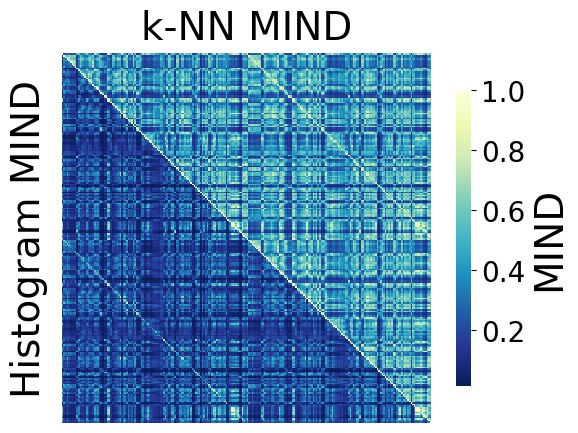

In [21]:
# Visualise avg networks

# ----- Define matrix indices ----- #
triu_ind = np.triu_indices(230, k=1)   # upper triangle (excluding diagonal)
tril_ind = np.tril_indices(230, k=-1)  # lower triangle (excluding diagonal)

# ----- Construct average k-NN and histogram networks ----- #
knn_mat = np.zeros((230, 230))
knn_mat[triu_ind] = KNN_edge_df_filt_adult.iloc[:, 4:].mean(axis=0).values  # mean edges across subjects
knn_mat += knn_mat.T  # symmetrize

hist_mat = np.zeros((230, 230))
hist_mat[triu_ind] = hist_edge_df_filt_adult.iloc[:, 4:].mean(axis=0).values
hist_mat += hist_mat.T  # symmetrize

# ----- Combine into one matrix: k-NN (upper), Histogram (lower) ----- #
mat = np.ones((230, 230))
mat[triu_ind] = knn_mat[triu_ind]
mat[tril_ind] = hist_mat[tril_ind]

# ----- Optionally plot individual networks ----- #
if 0:  
    ax = sns.heatmap(knn_mind, cmap='YlGnBu_r', xticklabels=[], yticklabels=[], 
                cbar_kws={'shrink': 0.8, 'label': 'MIND'})
    cbar = ax.collections[0].colorbar  
    cbar.ax.yaxis.label.set_size(20) 
    plt.title('k-NN', fontsize=24, pad=10)
    ax.set_aspect("equal")
    plt.show()

    ax = sns.heatmap(hist_mind, cmap='YlGnBu_r', xticklabels=[], yticklabels=[], 
                cbar_kws={'shrink': 0.8, 'label': 'MIND'})
    cbar = ax.collections[0].colorbar  
    cbar.ax.yaxis.label.set_size(20) 
    plt.title('Hist', fontsize=24, pad=10)
    ax.set_aspect("equal")
    plt.show()

# ----- Plot combined comparison heatmap ----- #
ax = sns.heatmap(mat, cmap='YlGnBu_r', xticklabels=[], yticklabels=[], 
            cbar_kws={'shrink': 0.8, 'label': 'MIND'}, rasterized=True)
cbar = ax.collections[0].colorbar  
cbar.ax.yaxis.label.set_size(28) 
cbar.ax.tick_params(labelsize=20)
plt.title('k-NN MIND', fontsize=28, pad=10)
plt.ylabel('Histogram MIND', fontsize=28, labelpad=10)
ax.set_aspect("equal")
plt.show()

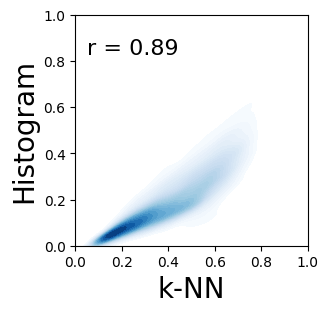

In [22]:
# Correlating group networks

# ----- Prepare dataframe of average edge weights ----- #
to_plot = pd.DataFrame({
    'KNN': KNN_edge_df_filt_adult.iloc[:, 4:].mean(axis=0).values,   # mean k-NN edges
    'hist': hist_edge_df_filt_adult.iloc[:, 4:].mean(axis=0).values  # mean histogram edges
})

# ----- Compute Spearman correlation ----- #
r, _ = spearmanr(to_plot['KNN'], to_plot['hist'])

# ----- Plot density scatter (kdeplot) ----- #
plt.figure(figsize=(3, 3))
ax = sns.kdeplot(data=to_plot, x='KNN', y='hist', fill=True, cmap='Blues', levels=30)

# Axis labels and limits
plt.xlabel('k-NN', fontsize=20)
plt.ylabel('Histogram', fontsize=20)
plt.xlim([0, 1])
plt.ylim([0, 1])

# Add correlation text
x1, x2 = ax.get_xlim(); y1, y2 = ax.get_ylim()
ax.text((x1 + 0.05*(x2-x1)), (y1 + 0.83*(y2-y1)), f'r = {r:.2f}', fontsize=16)

plt.show()

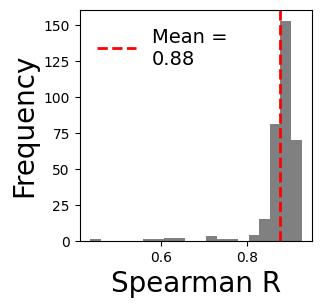

In [23]:
#### Correlate individual subjects

# ----- Compute subject-wise correlations ----- #
r_list = []
for i in range(KNN_edge_df_filt_adult.shape[0]):
    r_list.append(
        spearmanr(
            KNN_edge_df_filt_adult.iloc[i, 4:].values,
            hist_edge_df_filt_adult.iloc[i, 4:].values
        )[0]
    )

# Mean correlation across subjects
mean_r = np.mean(r_list)

# ----- Plot histogram of correlations ----- #
plt.figure(figsize=(3, 3))
plt.hist(r_list, bins=20, rasterized=True, color='Gray')
plt.axvline(mean_r, label=f'Mean = \n{mean_r:.2f}', color='red', linestyle='--', linewidth=2)
plt.xlabel('Spearman R', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.legend(frameon=False, fontsize=14)
plt.show()

#### **1.7 Compare optimised Histogram and k-NN MIND networks on anatomical benchmarks**

Confidence intervals are estimated using population bootstrapping.

Start with the cytoarchitectonic class benchmark

In [234]:
edges_dict = {
    'KNN': KNN_edge_df_filt_adult.iloc[:, 4:].values,   # subject × edges
    'hist': hist_edge_df_filt_adult.iloc[:, 4:].values
}

# ----- Load lookup table ----- #
lut = pd.read_csv('data/lut_master.csv', index_col=0)

# ----- Define network setup ----- #
triu_ind = np.triu_indices(230, k=1)    # indices for upper triangle
dens_list = np.arange(5, 105, 5)        # densities to threshold
nperm = 500                             # number of bootstraps

# ----- Initialise dictionaries to hold results ----- #
emp_pct_intraclass_dict = { 'KNN': None, 'hist': None }   # empirical curves
boot_pct_intraclass_dict = { 'KNN': None, 'hist': None }  # bootstrap curves

# ----- Loop through MIND estimators ----- #
for MIND_type in list(edges_dict.keys()):
    print(f'Calculating % intra-class for {MIND_type}')

    # ----- Build average network ----- #
    edges_all = edges_dict[MIND_type]   # subject × edges
    edges_mean = edges_all.mean(axis=0)
    net = np.zeros((230, 230))
    net[triu_ind] = edges_mean
    net = net + net.T
    net = net[0:115]   # restrict to subset of ROIs

    # ----- Empirical % intra-class vs density ----- #
    print('Calculating empirical')
    emp_pct_intraclass = []
    for dens in dens_list:
        net_thresh = threshold_network(net, dens)
        pct_intraclass = get_pct_intraclass(net_thresh, lut.type)
        emp_pct_intraclass.append(pct_intraclass)
    emp_pct_intraclass_dict[MIND_type] = emp_pct_intraclass

    # ----- Bootstrap resampling ----- #
    print('Calculating bootstraps')
    boot_pct_intraclass_all = np.zeros((nperm, len(dens_list)))

    for i in tqdm(range(nperm)):
        # Resample subjects with replacement
        boot_indices = np.random.choice(np.arange(edges_all.shape[0]), edges_all.shape[0], replace=True)
        boot_edges = edges_all[boot_indices].mean(axis=0)
        
        # Build bootstrapped network
        boot_net = np.zeros((230, 230))
        boot_net[triu_ind] = boot_edges
        boot_net = boot_net + boot_net.T
        
        # Compute % intra-class across densities
        boot_pct_intraclass = []
        for dens in dens_list:
            boot_net_thresh = threshold_network(boot_net, dens)
            pct_intraclass = get_pct_intraclass(boot_net_thresh, lut.type)
            boot_pct_intraclass.append(pct_intraclass)
    
        boot_pct_intraclass_all[i, :] = boot_pct_intraclass

    boot_pct_intraclass_dict[MIND_type] = boot_pct_intraclass_all

Calculating % intra-class for KNN
Calculating empirical
Calculating bootstraps


100%|██████████| 500/500 [06:46<00:00,  1.23it/s]


Calculating % intra-class for hist
Calculating empirical
Calculating bootstraps


100%|██████████| 500/500 [06:46<00:00,  1.23it/s]


/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_42982/3732452478.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


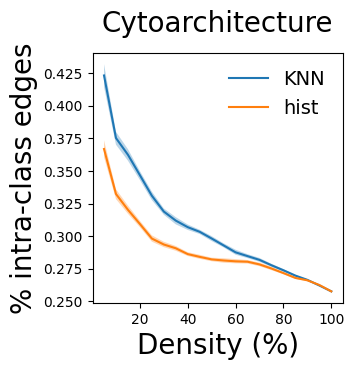

In [235]:
# ----- Plotting bootstrap results ----- #

# Create figure
fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.add_axes([0, 0, 1, 1])

# Loop through MIND types (KNN, Histogram)
for MIND_type in list(edges_dict.keys()):
    # Compute bootstrap 90% CI and mean
    boot_lower = np.percentile(boot_pct_intraclass_dict[MIND_type], 5, axis=0)
    boot_upper = np.percentile(boot_pct_intraclass_dict[MIND_type], 95, axis=0)
    boot_mean = np.mean(boot_pct_intraclass_dict[MIND_type], axis=0)

    # Plot mean with shaded confidence interval
    plt.plot(dens_list, boot_mean, label=MIND_type, linestyle='-')
    plt.fill_between(dens_list, boot_lower, boot_upper, alpha=0.3, label=None)

# Axis labels and legend
plt.xlabel('Density (%)', fontsize=20)
plt.ylabel('% intra-class edges', fontsize=20)
plt.legend(fontsize=14, frameon=False)

# Layout and title
plt.tight_layout()
plt.title('Cytoarchitecture', fontsize=20, pad=15)
plt.show()

Percent interhemispheric edges

In [236]:
# ----- Setup ----- #

# Indices for upper triangle of adjacency
triu_ind = np.triu_indices(230, k=1)

# Densities to threshold
dens_list = np.arange(0.05, 50, 0.05)

# Number of bootstrap permutations
nperm = 500

# Initialise dictionaries for results
emp_pct_interhem_dict = { 'KNN': None, 'hist': None }   # empirical curves
boot_pct_interhem_dict = { 'KNN': None, 'hist': None }  # bootstrap curves

# ----- Loop over MIND estimators ----- #
for MIND_type in list(edges_dict.keys()):
    print(f'Calculating % inter-hemispheric for {MIND_type}')

    # Build group-mean network
    edges_all = edges_dict[MIND_type]             # subject × edges
    edges_mean = edges_all.mean(axis=0)           # average across subjects
    net = np.zeros((230, 230))
    net[triu_ind] = edges_mean
    net = net + net.T

    # ----- Empirical % inter-hemispheric vs density ----- #
    print('Calculating empirical')
    emp_pct_interhem = []
    for dens in dens_list:
        net_thresh = threshold_network(net, dens)
        pct_interhem = get_pct_interhemispheric(net_thresh)
        emp_pct_interhem.append(pct_interhem)
    emp_pct_interhem_dict[MIND_type] = emp_pct_interhem

    # ----- Bootstrap resampling ----- #
    print('Calculating bootstraps')
    boot_pct_interhem_all = np.zeros((nperm, len(dens_list)))

    for i in tqdm(range(nperm)):
        # Resample subjects with replacement
        boot_indices = np.random.choice(np.arange(edges_all.shape[0]), edges_all.shape[0], replace=True)
        boot_edges = edges_all[boot_indices].mean(axis=0)

        # Build bootstrapped network
        boot_net = np.zeros((230, 230))
        boot_net[triu_ind] = boot_edges
        boot_net = boot_net + boot_net.T
        
        # Compute % inter-hemispheric across densities
        boot_pct_interhem = []
        for dens in dens_list:
            boot_net_thresh = threshold_network(boot_net, dens)
            pct_interhem = get_pct_interhemispheric(boot_net_thresh)
            boot_pct_interhem.append(pct_interhem)
    
        boot_pct_interhem_all[i, :] = boot_pct_interhem

    # Store bootstrap results
    boot_pct_interhem_dict[MIND_type] = boot_pct_interhem_all

Calculating % inter-hemispheric for KNN
Calculating empirical
Calculating bootstraps


100%|██████████| 500/500 [05:52<00:00,  1.42it/s]


Calculating % inter-hemispheric for hist
Calculating empirical
Calculating bootstraps


100%|██████████| 500/500 [06:00<00:00,  1.39it/s]


/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_42982/722481080.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


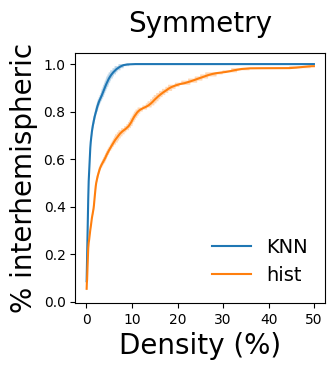

In [237]:
# ----- Plotting bootstrap results (interhemispheric) ----- #

# Create figure
fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.add_axes([0, 0, 1, 1])

# Loop over MIND estimators (KNN, Histogram)
for MIND_type in list(edges_dict.keys()):
    # Compute 90% bootstrap CI and mean
    boot_lower = np.percentile(boot_pct_interhem_dict[MIND_type], 5, axis=0)
    boot_upper = np.percentile(boot_pct_interhem_dict[MIND_type], 95, axis=0)
    boot_mean = np.mean(boot_pct_interhem_dict[MIND_type], axis=0)

    # Plot mean ± CI
    plt.plot(dens_list, boot_mean, label=MIND_type, linestyle='-')
    plt.fill_between(dens_list, boot_lower, boot_upper, alpha=0.3, label=None)

# Axis labels and legend
plt.xlabel('Density (%)', fontsize=20)
plt.ylabel('% interhemispheric', fontsize=20)
plt.legend(fontsize=14, frameon=False)

# Layout and title
plt.tight_layout()
plt.title('Symmetry', fontsize=20, pad=15)
plt.show()

Tract tracing benchmark

In [238]:
# ----- Load lookup tables ----- #
lut = pd.read_csv('data/lut_master.csv', index_col=0)
lut_lh = lut[lut['Side'] == 'L']   # left hemisphere ROIs

# ----- Load tract tracing matrix ----- #
tt = pd.read_csv('data/tract_tracing_matrix_edge_complete.csv', index_col=0)
tt_rois = tt.columns.tolist()

# Indices to align MIND networks to tract tracing ROIs
tt_roi_ind = lut_lh[lut_lh['ROI'].isin(tt_rois)].index.tolist()
tt_triu_ind = np.triu_indices(len(tt_roi_ind), k=1)
tt_triu = tt.values[tt_triu_ind]   # upper triangle of tract tracing matrix

# ----- Parameters ----- #
dens_list = np.arange(0.05, 100, 0.05)  # densities to threshold
nperm = 500                             # number of bootstraps

# Initialise result dictionaries
emp_tt_r_dict = { 'KNN': None, 'hist': None }    # empirical correlations
boot_tt_r_dict = { 'KNN': None, 'hist': None }   # bootstrap correlations

# ----- Loop over MIND estimators ----- #
for MIND_type in list(edges_dict.keys()):
    print(f'Calculating tract tracing correlations for {MIND_type}')

    # Build group-mean network
    edges_all = edges_dict[MIND_type]          # subject × edges
    edges_mean = edges_all.mean(axis=0)        # average across subjects
    net = np.zeros((230, 230))
    net[triu_ind] = edges_mean
    net = net + net.T

    # Filter network to tract tracing ROIs
    net_filt = net[tt_roi_ind, :][:, tt_roi_ind]

    # ----- Empirical correlation vs density ----- #
    print('Calculating empirical')
    emp_tt_r_list = []
    for dens in dens_list:
        net_thresh = threshold_network(net_filt, dens)
        net_thresh_triu = net_thresh[tt_triu_ind]
        emp_tt_r_list.append(spearmanr(net_thresh_triu, tt_triu)[0])
    emp_tt_r_dict[MIND_type] = emp_tt_r_list

    # ----- Bootstrap resampling ----- #
    print('Calculating bootstraps')
    boot_tt_r_all = np.zeros((nperm, len(dens_list)))

    for i in tqdm(range(nperm)):
        # Resample subjects with replacement
        boot_indices = np.random.choice(np.arange(edges_all.shape[0]), edges_all.shape[0], replace=True)
        boot_edges = edges_all[boot_indices].mean(axis=0)

        # Build bootstrapped network
        boot_net = np.zeros((230, 230))
        boot_net[triu_ind] = boot_edges
        boot_net = boot_net + boot_net.T
        boot_net_filt = boot_net[tt_roi_ind, :][:, tt_roi_ind]
        
        # Correlations across densities
        boot_tt_r = []
        for dens in dens_list:
            boot_net_thresh = threshold_network(boot_net_filt, dens)
            boot_net_thresh_triu = boot_net_thresh[tt_triu_ind]
            boot_tt_r.append(spearmanr(boot_net_thresh_triu, tt_triu)[0])
    
        boot_tt_r_all[i, :] = boot_tt_r

    # Store bootstrap results
    boot_tt_r_dict[MIND_type] = boot_tt_r_all

Calculating tract tracing correlations for KNN
Calculating empirical
Calculating bootstraps


100%|██████████| 500/500 [05:37<00:00,  1.48it/s]


Calculating tract tracing correlations for hist
Calculating empirical
Calculating bootstraps


100%|██████████| 500/500 [05:36<00:00,  1.49it/s]


/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_42982/1725033637.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


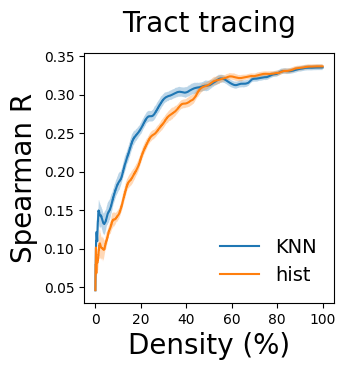

In [239]:
# ----- Plotting bootstrap results (tract tracing correlations) ----- #

# Create figure
fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.add_axes([0, 0, 1, 1])

# Loop through MIND estimators (KNN, Histogram)
for MIND_type in list(edges_dict.keys()):
    # Compute bootstrap 90% CI and mean
    boot_lower = np.percentile(boot_tt_r_dict[MIND_type], 5, axis=0)
    boot_upper = np.percentile(boot_tt_r_dict[MIND_type], 95, axis=0)
    boot_mean = np.mean(boot_tt_r_dict[MIND_type], axis=0)

    # Plot mean curve with shaded CI
    plt.plot(dens_list, boot_mean, label=MIND_type, linestyle='-')
    plt.fill_between(dens_list, boot_lower, boot_upper, alpha=0.3, label=None)

# Axis labels and title
plt.xlabel('Density (%)', fontsize=20)
plt.ylabel('Spearman R', fontsize=20)
plt.title('Tract tracing', fontsize=20, pad=15)

# Legend
plt.legend(fontsize=14, frameon=False)

# Layout and show
plt.tight_layout()
plt.show()

#### **1.8 Compare optimised Histogram and k-NN MIND networks on age prediction task**

In [24]:
# Generate train/test split using repeated stratified K-fold CV (stratified by Sex)

dummy_X = np.zeros(KNN_edge_df_filt_dev.shape[0]).reshape(-1, 1)

# Define repeated stratified K-Fold
n_splits = 5; n_repeats = 10
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=270900)

outer_split_dict = {}

for i, (train_index, test_index) in enumerate(rskf.split(dummy_X, covar_df_filt_dev['Sex']), start=1):
    outer_split_dict[i] = {"train": list(train_index), "test": list(test_index)}

In [9]:
# Create a pipeline that combines multiple models
pipe = Pipeline([
    ('model', None),
])
# Initialise data and pipeline
init_dict = {
    'KNN degree': {
        'df':KNN_degree_df_filt_dev,
        'param_grid': [
            {
                'model': [SVR()],
                'model__C': [0.1, 1, 10, 100],
                'model__gamma': ['scale'],
                'model__kernel': ['rbf']
            },
            {
                'model': [GaussianProcessRegressor()],
                'model__kernel': [DotProduct() + WhiteKernel(noise_level_bounds=(1e-10, np.inf))]
            }
        ]
    },
    'hist degree': {
        'df':hist_degree_df_filt_dev,
        'param_grid': [
            {
                'model': [SVR()],
                'model__C': [0.1, 1, 10, 100],
                'model__gamma': ['scale'],
                'model__kernel': ['rbf']
            },
            {
                'model': [GaussianProcessRegressor()],
                'model__kernel': [DotProduct() + WhiteKernel(noise_level_bounds=(1e-10, np.inf))]
            }
        ]
    },
    'KNN edge': {
        'df':KNN_edge_df_filt_dev,
        'param_grid': [
            {
                'model': [GaussianProcessRegressor()],
                'model__kernel': [DotProduct() + WhiteKernel(noise_level_bounds=(1e-10, np.inf))]
            }
        ]
    },
    'hist edge': {
        'df':hist_edge_df_filt_dev,
        'param_grid': [
            {
                'model': [GaussianProcessRegressor()],
                'model__kernel': [DotProduct() + WhiteKernel(noise_level_bounds=(1e-10, np.inf))]
            }
        ]
    },
}

# Initialise df to hold cross validated mean MAE of each model across folds
all_dfs = []

for predictor in list(init_dict.keys()):
    params_df = pd.DataFrame(list(ParameterGrid(init_dict[predictor]['param_grid'])))
    params_df = pd.concat([
        pd.DataFrame({'predictor':[predictor]*params_df.shape[0]}),
        params_df
    ],axis=1)

    all_dfs.append(params_df)

all_models_df = pd.concat(all_dfs, ignore_index=True)
all_models_performance_df = pd.concat([
    all_models_df,
    pd.DataFrame(np.zeros((all_models_df.shape[0], n_splits*n_repeats)), columns=range(1, n_splits*n_repeats+1))
], axis=1)

best_models_performance_df = pd.DataFrame({
    'predictor': sum([[predictor] * (n_splits * n_repeats) for predictor in init_dict.keys()], []),
    'fold': list(range(1, n_splits * n_repeats + 1)) * len(init_dict),
    'mae': np.zeros(n_splits * n_repeats * len(init_dict)),
    'partial_r': np.zeros(n_splits * n_repeats * len(init_dict))
})

In [10]:
# Train models, store results

for predictor in list(init_dict.keys()):
    # Get predictor df
    df = init_dict[predictor]['df'].copy()
    
    # Get inputs
    X = df.iloc[:, 4:]
    y = df['Age'].copy()

    # Outer loop
    for fold in tqdm(outer_split_dict.keys()):        
        # Split outer data
        train_index = outer_split_dict[fold]['train']
        test_index = outer_split_dict[fold]['test']
        
        X_train_outer, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test = y.iloc[train_index], y.iloc[test_index]
        covar_train_outer, covar_test = covar_df_filt_dev.iloc[train_index], covar_df_filt_dev.iloc[test_index]
        
        # Scale data
        scaler = preprocessing.StandardScaler().fit(X_train_outer)
        X_train_outer_scaled = scaler.transform(X_train_outer)
        X_test_scaled = scaler.transform(X_test)

        # Inner loop

        # Generate inner train/test indices
        y_inner_cv = covar_train_outer['Sex'].values
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=270900).split(X=np.zeros_like(y_inner_cv), y=y_inner_cv)

        # Use GridSearchCV to search over the hyperparameters
        optimal_params = GridSearchCV(
                pipe, 
                init_dict[predictor]['param_grid'],
                cv=inner_cv,
                scoring='neg_mean_absolute_error',
                verbose=0 #2 for output on each model being cross validated
            )
        
        # Fit GridSearchCV
        optimal_params.fit(X_train_outer_scaled, y_train_outer)
        best_model = optimal_params.best_estimator_

        # Append mean MSE across internal folds for each model
        all_models_performance_df.loc[
            all_models_performance_df['predictor'] == predictor,
            fold
        ] = -optimal_params.cv_results_['mean_test_score']
        
        # Evaluate best model on outer test set
        y_pred = best_model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        
        eval_df = pd.DataFrame({
            'test':y_test,
            'pred':y_pred,
            'sex':covar_test['Sex'],
            'etiv':covar_test['etiv']
        })
        
        partial_r = pg.partial_corr(data=eval_df, 
                                    x='test', 
                                    y='pred', 
                                    covar=['sex', 'etiv'],
                                    method='spearman').iloc[0,1]
        
        # Append
        best_models_performance_df.loc[
            (best_models_performance_df['predictor'] == predictor) &
            (best_models_performance_df['fold'] == fold),
             'mae'
        ] = mae

        best_models_performance_df.loc[
            (best_models_performance_df['predictor'] == predictor) &
            (best_models_performance_df['fold'] == fold),
             'partial_r'
        ] = partial_r

all_models_performance_df.to_csv('all_models_performance_df.csv')
best_models_performance_df.to_csv('best_models_performance_df.csv')

100%|██████████| 50/50 [37:20<00:00, 44.81s/it]


#### **1.9 Visualise results of age prediction task**

In [14]:
# Import results
best_models_performance_df = pd.read_csv('output/SF2-4/best_models_performance_df.csv', index_col=0)
all_models_performance_df = pd.read_csv('output/SF2-4/all_models_performance_df.csv', index_col=0)

# Get folds
dummy_X = np.zeros(KNN_edge_df_filt_dev.shape[0]).reshape(-1, 1)

# Define repeated stratified K-Fold
n_splits = 5; n_repeats = 10
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=270900)

outer_split_dict = {}

for i, (train_index, test_index) in enumerate(rskf.split(dummy_X, covar_df_filt_dev['Sex']), start=1):
    outer_split_dict[i] = {"train": list(train_index), "test": list(test_index)}

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

edge_KNN vs. edge_Hist: Wilcoxon test (paired samples) with Bonferroni correction, P_val:1.188e-02 Stat=3.560e+02
degree_KNN vs. degree_Hist: Wilcoxon test (paired samples) with Bonferroni correction, P_val:6.082e-07 Stat=1.460e+02


/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46750/3776123092.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Degree', 'Edge'], fontsize=14)
/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46750/3776123092.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


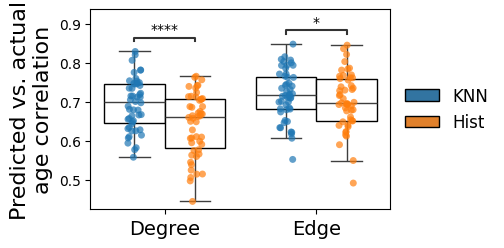

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

edge_KNN vs. edge_Hist: Wilcoxon test (paired samples) with Bonferroni correction, P_val:5.062e-01 Stat=5.180e+02
degree_KNN vs. degree_Hist: Wilcoxon test (paired samples) with Bonferroni correction, P_val:8.115e-09 Stat=9.100e+01


/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46750/3776123092.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Degree', 'Edge'], fontsize=14)
/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46750/3776123092.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


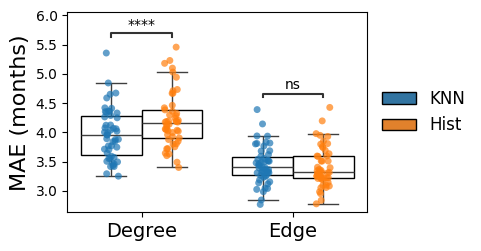

In [15]:
from statannotations.Annotator import Annotator
import seaborn as sns
import matplotlib.pyplot as plt

n_outer = 50  # adjust if your actual n_outer differs

# Copy and define supercat and subcat
all_performance = best_models_performance_df.copy()
all_performance['supercat'] = ['degree'] * n_outer * 2 + ['edge'] * n_outer * 2
all_performance['subcat'] = ['KNN'] * n_outer + ['Hist'] * n_outer + ['KNN'] * n_outer + ['Hist'] * n_outer
all_performance['mae'] = all_performance['mae']*12

df = all_performance
x = 'supercat'

for y in ['partial_r', 'mae']:
    hue = 'subcat'
    order = ['degree', 'edge']
    hue_order = ['KNN', 'Hist']

    # Define statistical comparison pairs
    pairs = [
        (('degree', 'KNN'), ('degree', 'Hist')),
        (('edge', 'KNN'), ('edge', 'Hist'))
    ]

    # Define consistent colors
    palette = {
        'KNN': '#1f77b4',
        'Hist': '#ff7f0e',
    }

    fig = plt.figure(figsize=(3, 2))
    ax = fig.add_axes([0, 0, 1, 1])
    sns.boxplot(
        data=df, x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        palette=palette, showfliers=False, ax=ax,
        boxprops={'facecolor': 'white', 'edgecolor': 'black'}
    )

    # Overlay stripplot
    sns.stripplot(
        data=df, x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        dodge=True, size=5, alpha=0.7,
        palette=palette, ax=ax
    )

    # Remove duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    #if y == 'partial_r': 
    #    loc= 'lower right'
    #else:
    #    loc= 'upper right'
    ax.legend(
        handles[:len(hue_order)], labels[:len(hue_order)],
        loc='center left', bbox_to_anchor=(1.0, 0.5),
        fontsize=12, frameon=False
    )

    # Add statistical annotations
    annot = Annotator(ax, pairs, data=df, x=x, y=y, hue=hue, order=order, hue_order=hue_order)
    annot.configure(test='Wilcoxon', text_format='star', comparisons_correction='Bonferroni', loc='inside')
    annot.apply_and_annotate()

    # Labeling
    ax.set_xlabel('')
    if y == 'partial_r':
        ax.set_ylabel('Predicted vs. actual\nage correlation', fontsize=16)
    else:
        ax.set_ylabel('MAE (months)', fontsize=16)
    ax.set_xticklabels(['Degree', 'Edge'], fontsize=14)
    plt.tight_layout()
    plt.show()
